In [73]:
import tensorflow as tf
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import preprocessing
from sklearn import model_selection
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [74]:
data = pd.read_csv('data.csv', index_col = 0)

In [75]:
data = data.assign(Ret1M  = data.Close.groupby(data.Tick).pct_change(1))
data = data.assign(Ret3M  = data.Close.groupby(data.Tick).pct_change(3))
data = data.assign(Ret6M  = data.Close.groupby(data.Tick).pct_change(6))
data = data.assign(Ret12M = data.Close.groupby(data.Tick).pct_change(12))

In [76]:
data = data.assign(MOM3M  = data.Close.groupby(data.Tick).shift(1)/data.Close.groupby(data.Tick).shift(4)  - 1)
data = data.assign(MOM6M  = data.Close.groupby(data.Tick).shift(1)/data.Close.groupby(data.Tick).shift(6)  - 1)
data = data.assign(MOM12M = data.Close.groupby(data.Tick).shift(1)/data.Close.groupby(data.Tick).shift(12) - 1)

In [77]:
# Changing "Date" to datetime format
data['Date'] = pd.to_datetime(data['Date'])

In [78]:
data.dropna(axis=0, how='any',inplace=True) # Drop first 12 rows since we dont' have some factors (e.g. ret12) # Also, we might now need data from 1999 to predict current movements

In [79]:
#Sets index of dataframe to the stock's tick for sorting purposes
data.set_index("Tick",inplace=True)

#Extracts data for individual stock
def get_stock_data(data,stock):
    return data.loc[stock]

### Standardising the data - Cross sectional MinMax

In [80]:
%%capture
numeric_columns = list(data.columns.values[data.dtypes.values == float]) # Keeeping only numeric columns


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1)) #Defyning the scalar object

def get_cross_section(data,date): # Used
    return data[data.Date == date]


standardized_data = pd.DataFrame(columns = list(data.columns.values).append("Quintile"))

for date in set(data.Date.values):
    CS_numeric_date = get_cross_section(data,date)[numeric_columns] # Extracting numeric columns from the cross section
    transformed = scaler.fit_transform(CS_numeric_date) # cross-sectional standardization
    scaled_features_df = pd.DataFrame(transformed, index=CS_numeric_date.index, columns=CS_numeric_date.columns) # transforming into dataframe
    scaled_features_df.insert(0, "Date", date) # Adding back the corresponding date
    
    
    ################ Calculating quintiles ##################
    q_20 = scaled_features_df["Ret1M"].quantile(q=0.2, interpolation='linear')
    q_40 = scaled_features_df["Ret1M"].quantile(q=0.4, interpolation='linear')
    q_60 = scaled_features_df["Ret1M"].quantile(q=0.6, interpolation='linear')
    q_80 = scaled_features_df["Ret1M"].quantile(q=0.8, interpolation='linear')
    
    # Encoding: 4 is in 1st quantile, 3 if in second quantile ...
    idx1 = np.where((scaled_features_df['Ret1M']<= q_20))
    idx2 = np.where((scaled_features_df['Ret1M']> q_20) & (scaled_features_df['Ret1M']<= q_40))
    idx3 = np.where((scaled_features_df['Ret1M']> q_40) & (scaled_features_df['Ret1M']<= q_60))
    idx4 = np.where((scaled_features_df['Ret1M']> q_60) & (scaled_features_df['Ret1M']<= q_80))
    idx5 = np.where((scaled_features_df['Ret1M']> q_80))
    
    scaled_features_df["Quintile"] = 999 # Initializing value
    scaled_features_df["Quintile"].iloc[idx1] = 0
    scaled_features_df["Quintile"].iloc[idx2] = 1
    scaled_features_df["Quintile"].iloc[idx3] = 2
    scaled_features_df["Quintile"].iloc[idx4] = 3
    scaled_features_df["Quintile"].iloc[idx5] = 4
    
    
    standardized_data = pd.concat([standardized_data, scaled_features_df]) # Adding the data from this date to the whole standardized database
    
    
standardized_data.sort_values(by=['Date'],inplace = True)

### Shifting Quintiles to make predictions

In [81]:
%%capture
standardized_data_with_target = pd.DataFrame(columns = list(standardized_data.columns.values).append("Target_Shifted_Quintile_1"))

for tick in set(standardized_data.index.values):
    TS_tick = standardized_data[standardized_data.index == tick]
    
    
    TS_tick["Target_Shifted_Quintile_1"] = TS_tick[["Quintile"]].shift(-1)
    TS_tick["Target_Shifted_Quintile_1"][-1] = 999 # Before converting to int we have to get rid of the nan (last value of the shifted)
    TS_tick["Target_Shifted_Quintile_1"] = TS_tick["Target_Shifted_Quintile_1"].astype(int)
    
    standardized_data_with_target = pd.concat([standardized_data_with_target, TS_tick]) # Adding the data from this date to the whole standardized database
    
    
standardized_data_with_target["Temp"] = standardized_data_with_target.index
standardized_data_with_target.sort_values(by=['Date', 'Temp'], inplace=True)
standardized_data_with_target.sort_values(by=['Date', 'Temp'], inplace=True)
standardized_data_with_target.drop(['Temp'],axis='columns', inplace=True)

### Drop the last timestep - We don't have the target for it

In [82]:
standardized_data_with_target.reset_index(level=0, inplace=True)

standardized_data_with_target.drop(standardized_data_with_target[standardized_data_with_target.Target_Shifted_Quintile_1 == 999].index,axis='rows',inplace = True)

standardized_data_with_target.set_index("Tick",inplace = True)

### Working with a single stock

In [83]:
#Separates data into target (Closing Price) and predictors (excluding date)
def split_stock_data(stock_data):
    y = stock_data['Target_Shifted_Quintile_1']
    X = stock_data.drop(['Target_Shifted_Quintile_1','Date'],axis='columns', inplace=False) #This way we don't remove the data information from the dataset
    return X,y

In [84]:
# Create dataset for LSTM model

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [85]:

sd   = get_stock_data(standardized_data_with_target,'INTC') # Select a single stock
X,y  = split_stock_data(sd)

#Splits data into training and testing sets
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X,y,test_size=0.125)

In [86]:
time_steps = 1
X_train,y_train = create_dataset(X_train, y_train, time_steps=time_steps)
X_test,y_test = create_dataset(X_test, y_test, time_steps=time_steps)

In [87]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(190, 1, 20)
(190,)
(27, 1, 20)
(27,)


In [88]:
# One-hot encoding
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 5)
y_test = to_categorical(y_test, 5)

In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# LSTM input_shape: (Samples,Time Steps, Features)
# Samples. One sequence is one sample. A batch is comprised of one or more samples.
# Time Steps. One time step is one point of observation in the sample.
# Features. One feature is one observation at a time step.

input_shape=(time_steps, 20) # 1 or more samples, time_steps time steps, and 20 features.


# create and fit the LSTM network
model = Sequential()


model.add(SimpleRNN(16, input_shape=input_shape,kernel_regularizer=l2(0.005), recurrent_regularizer=l2(0.005), bias_regularizer=l2(0.005)))


model.add(Dense(5, activation='softmax'))

#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'], )

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())


#,callbacks=[EarlyStopping(monitor='val_loss',patience=200, min_delta=0.0001)]
history = model.fit(X_train, y_train, epochs=200, batch_size=4,validation_split=0.2)






#history = model.fit(X_train, y_train, epochs = 100, batch_size = 8)


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 16)                592       
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 85        
Total params: 677
Trainable params: 677
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
38/38 [==============================] - 0s 5ms/step - loss: 1.8191 - acc: 0.2368 - val_loss: 1.8198 - val_acc: 0.1842
Epoch 2/200
38/38 [==============================] - 0s 980us/step - loss: 1.7541 - acc: 0.2171 - val_loss: 1.7779 - val_acc: 0.1579
Epoch 3/200
38/38 [==============================] - 0s 972us/step - loss: 1.7333 - acc: 0.1908 - val_loss: 1.7595 - val_acc: 0.1579
Epoch 4/200
38/38 [==============================] - 0s 1ms/step - loss: 1.7127 - acc: 0.2303 - val_loss: 1.7476 - v

38/38 [==============================] - 0s 1ms/step - loss: 1.5664 - acc: 0.2895 - val_loss: 1.7012 - val_acc: 0.1579
Epoch 59/200
38/38 [==============================] - 0s 1ms/step - loss: 1.5634 - acc: 0.3092 - val_loss: 1.7042 - val_acc: 0.1316
Epoch 60/200
38/38 [==============================] - 0s 1ms/step - loss: 1.5703 - acc: 0.2500 - val_loss: 1.7141 - val_acc: 0.1316
Epoch 61/200
38/38 [==============================] - 0s 1ms/step - loss: 1.5618 - acc: 0.2895 - val_loss: 1.7030 - val_acc: 0.1579
Epoch 62/200
38/38 [==============================] - 0s 1ms/step - loss: 1.5648 - acc: 0.3092 - val_loss: 1.6960 - val_acc: 0.1842
Epoch 63/200
38/38 [==============================] - 0s 1ms/step - loss: 1.5653 - acc: 0.2895 - val_loss: 1.7094 - val_acc: 0.1579
Epoch 64/200
38/38 [==============================] - 0s 1ms/step - loss: 1.5618 - acc: 0.3289 - val_loss: 1.7012 - val_acc: 0.1579
Epoch 65/200
38/38 [==============================] - 0s 989us/step - loss: 1.5625 - acc:

38/38 [==============================] - 0s 978us/step - loss: 1.5333 - acc: 0.3026 - val_loss: 1.7260 - val_acc: 0.1579
Epoch 120/200
38/38 [==============================] - 0s 949us/step - loss: 1.5312 - acc: 0.3289 - val_loss: 1.7372 - val_acc: 0.1316
Epoch 121/200
38/38 [==============================] - 0s 942us/step - loss: 1.5308 - acc: 0.3289 - val_loss: 1.7307 - val_acc: 0.1316
Epoch 122/200
38/38 [==============================] - 0s 976us/step - loss: 1.5287 - acc: 0.3289 - val_loss: 1.7384 - val_acc: 0.1579
Epoch 123/200
38/38 [==============================] - 0s 956us/step - loss: 1.5297 - acc: 0.3224 - val_loss: 1.7321 - val_acc: 0.1316
Epoch 124/200
38/38 [==============================] - 0s 986us/step - loss: 1.5263 - acc: 0.3026 - val_loss: 1.7276 - val_acc: 0.1579
Epoch 125/200
38/38 [==============================] - 0s 985us/step - loss: 1.5298 - acc: 0.2961 - val_loss: 1.7375 - val_acc: 0.1842
Epoch 126/200
38/38 [==============================] - 0s 1ms/step - 

38/38 [==============================] - 0s 964us/step - loss: 1.5067 - acc: 0.3289 - val_loss: 1.7566 - val_acc: 0.1316
Epoch 181/200
38/38 [==============================] - 0s 987us/step - loss: 1.5042 - acc: 0.3092 - val_loss: 1.7481 - val_acc: 0.1316
Epoch 182/200
38/38 [==============================] - 0s 1ms/step - loss: 1.5046 - acc: 0.3158 - val_loss: 1.7427 - val_acc: 0.1579
Epoch 183/200
38/38 [==============================] - 0s 976us/step - loss: 1.5142 - acc: 0.3289 - val_loss: 1.7417 - val_acc: 0.1316
Epoch 184/200
38/38 [==============================] - 0s 950us/step - loss: 1.5061 - acc: 0.3289 - val_loss: 1.7541 - val_acc: 0.1316
Epoch 185/200
38/38 [==============================] - 0s 980us/step - loss: 1.5086 - acc: 0.3158 - val_loss: 1.7497 - val_acc: 0.1316
Epoch 186/200
38/38 [==============================] - 0s 1ms/step - loss: 1.5093 - acc: 0.3289 - val_loss: 1.7523 - val_acc: 0.1316
Epoch 187/200
38/38 [==============================] - 0s 1ms/step - loss

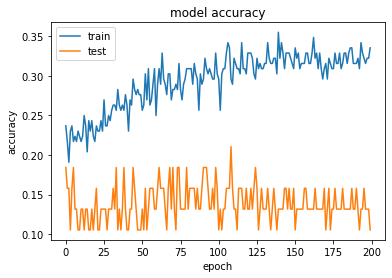

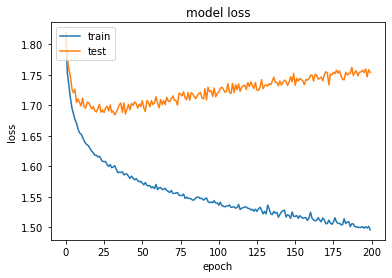

In [95]:
#  print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [56]:
predictions = model.predict(x=X_test, batch_size=4, verbose=0) 
rounded_predictions = np.argmax(predictions, axis=-1)

In [43]:
# Values count
y_test = np.argmax(y_test, axis=-1)
(unique, counts) = np.unique(y_test, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[0 5]
 [1 2]
 [2 2]
 [3 5]
 [4 8]]


In [44]:
print(rounded_predictions)
print(y_test)

[4 3 0 0 1 1 0 2 3 0 2 3 0 4 3 2 2 0 1 0 1 0]
[4 2 0 2 1 4 3 0 0 4 3 3 4 4 3 4 3 0 4 4 1 0]


In [45]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools

In [46]:
cm = confusion_matrix(y_true=y_test, y_pred=rounded_predictions)
print(cm)

[[3 0 1 1 0]
 [0 2 0 0 0]
 [1 0 0 1 0]
 [1 0 2 2 0]
 [3 2 1 0 2]]


In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[3 0 1 1 0]
 [0 2 0 0 0]
 [1 0 0 1 0]
 [1 0 2 2 0]
 [3 2 1 0 2]]


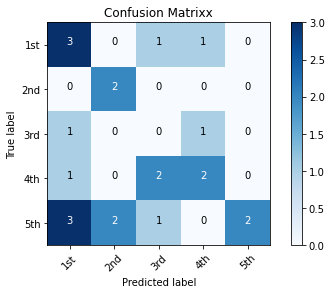

In [48]:
cm_plot_labels = ['1st','2nd','3rd','4th','5th']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrixx')